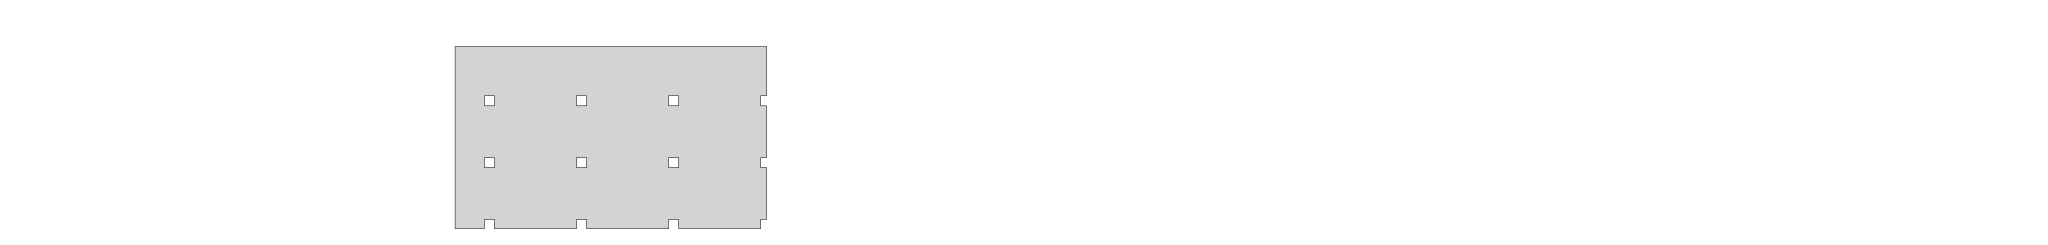

In [1]:
"""
Extinguisher.ipynb
TODO:
- [x] Get floor definition from Revit
- [x] Add Obstacles
- [ ] Add Doors (extinguisher to be closest to access points)
"""
__author__ = "Bob YX Lee"
import sys 
import os
import json
import drawsvg as dw
import random
from pprint import pprint
from copy import deepcopy

sys.path.append("./packages")

from geom.Line2D import Line2D

MM = 100

data = {}
# Get random data point
datafiles = os.listdir("./dataset")
data_path = os.path.join("./dataset", "test_api.json")#random.choice(datafiles))
data = {}
with open(data_path, "r") as f:
    data = json.loads(f.read())

d = dw.Drawing(4000, 480, origin = (-MM*4, -MM*2), id_prefix='pic')
dpath = dw.Path(stroke = 'black', fill = 'lightgray')
#print(data)
verts = data["room_dict"]["vertices"]
obs = data["room_dict"]["obstacles"]
for i, p in enumerate(verts):
    if i == 0: dpath.M(p[0]/MM, -p[1]/MM); continue
    dpath.L(p[0]/MM, -p[1]/MM);

for o in obs:
    for i, p in enumerate(o):
        if i == 0: dpath.M(p[0]/MM, -p[1]/MM); continue
        dpath.L(p[0]/MM, -p[1]/MM);
    
d.append(dpath)
d

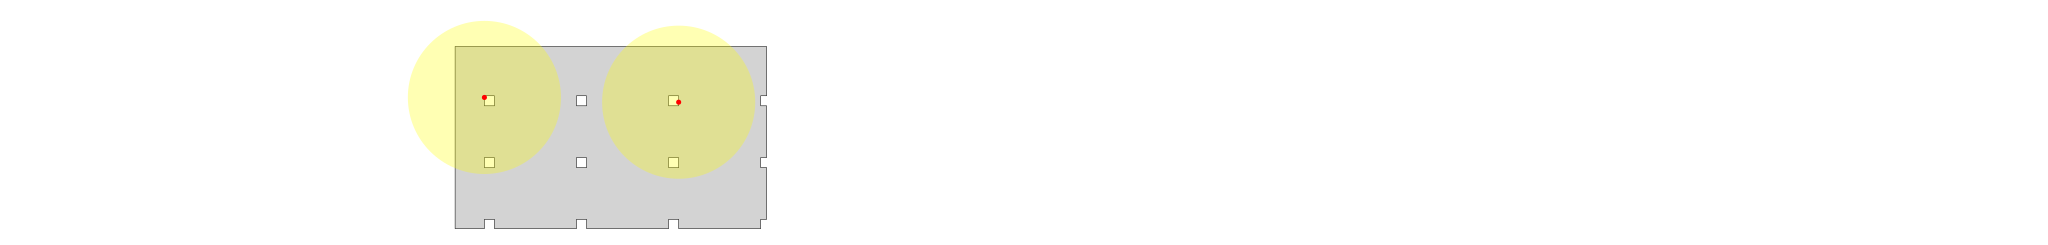

In [2]:
"""
PASS 1
TODO:
- Create iteration algorithm
"""
# Iterate through all possible combinations until boolean difference is 0
d3 = deepcopy(d)

def drawCoverage(d, pt):
    d.append(dw.Circle(pt[0]/MM, -pt[1]/MM, 15000/MM, fill='yellow', fill_opacity=0.3))
    d.append(dw.Circle(pt[0]/MM, -pt[1]/MM, 5, fill='red'))
    pass

exts = data["exts"]
for e in exts:
    drawCoverage(d3, e)
d3

[[92342.41385149435, 1237.723308779726], [92342.41385149435, -730.7806282281541], [90373.90991448646, -730.7806282281541], [90373.90991448646, 1237.723308779726], [92342.41385149435, 1237.723308779726]]
[[92342.41385149435, 1237.723308779726], [90373.90991448646, 1237.723308779726], [90373.90991448646, -730.7806282281541], [92342.41385149435, -730.7806282281541], [92342.41385149435, 1237.723308779726]]
106


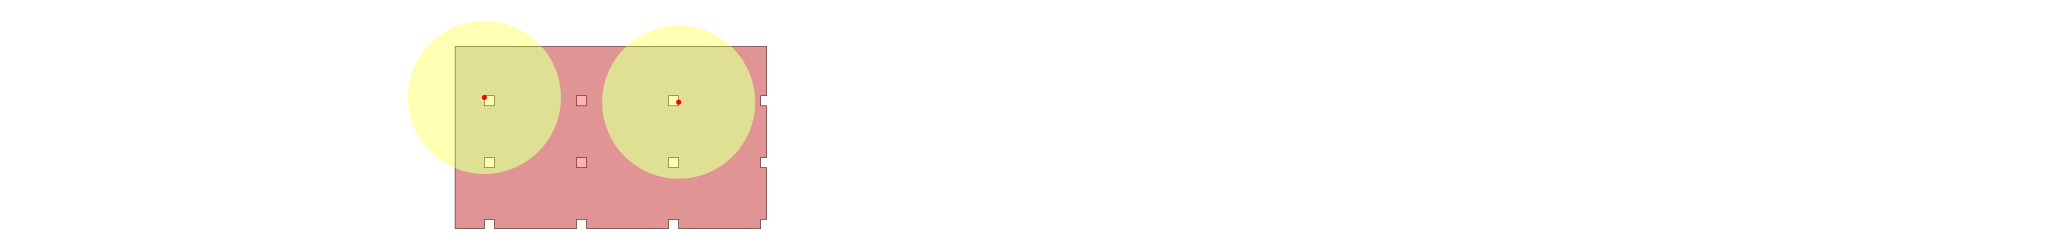

In [3]:
"""
Test pyclipper
"""
import numpy as np
import pyclipper

def polyArea(path):
    if len(path == 0): return 0
    x = np.array([point[0] for point in path])
    y = np.array([point[1] for point in path])
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1))) 

def drawPath(dwg, path, fill="yellow", fill_opacity = 0.3):
    dpath = dw.Path(fill = fill, fill_opacity = fill_opacity)
    for i, v in enumerate(path):
        if i == 0: dpath.M(v[0]/MM, -v[1]/MM); continue;
        dpath.L(v[0]/MM, -v[1]/MM)
    dwg.append(dpath)

def circle2D(radius, nv, center = (0,0), endpoint = False):
    theta = np.linspace(0, 2 * np.pi, nv, endpoint=endpoint)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)

    vertices = np.vstack((x,y)).T
    moved_verts = []
    for v in vertices:
        moved_verts.append((v[0]+center[0], v[1] + center[1]))
    return moved_verts

boundary = verts

boundary2d = []
for b in boundary:
    boundary2d.append((b[0], b[1]))
print(obs[0])
for o in obs:
    o.reverse()
print(obs[0])
ext2d = []
for e in exts:
    ext2d.append(circle2D(15000, 64, e))

d5 = deepcopy(d3)

pc = pyclipper.Pyclipper()
pc.AddPaths(ext2d, pyclipper.PT_CLIP, pyclipper.PFT_POSITIVE)
pc.AddPaths([boundary2d], pyclipper.PT_SUBJECT, pyclipper.PFT_POSITIVE)
# Handle obstacles. I think KIV this for now.
for o in obs:
    pc.AddPath(o, pyclipper.PT_SUBJECT, pyclipper.PFT_NEGATIVE)
sln = pc.Execute(pyclipper.CT_DIFFERENCE, pyclipper.PFT_POSITIVE, pyclipper.PFT_POSITIVE)

for diff in sln:
    print(len(diff))
    drawPath(d5, diff, "red")

if(len(sln) == 0):
    pass1 = True
d5

843
[54284.671069342075, -24779.337058674148]


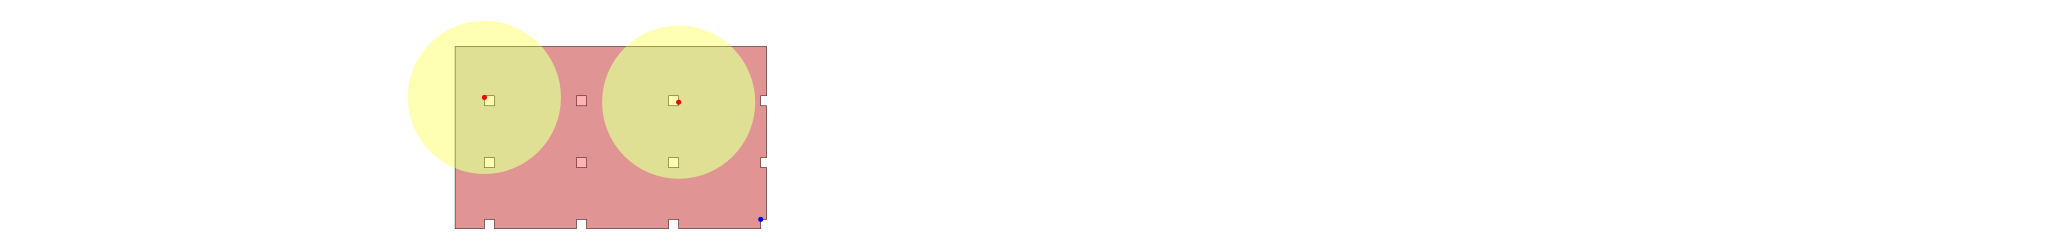

In [30]:
"""
Find the most remote point
If only 1 point, get point along wall furthest from the point
Otherwise, get average of all points
"""
from geom.Poly2D import getLines
from rhino3dm import Polyline, Point3d

def drawPt(d, pt):
    d.append(dw.Circle(pt[0]/MM, -pt[1]/MM, 5, fill='blue'))
    pass

def closestPt(point, others):
    others = np.array(others)
    distances = np.linalg.norm(others - point, axis = 1)
    c_idx = np.argmin(distances)
    return others[c_idx]

def furthestPt(point, others):
    others = np.array(others)
    distances = np.linalg.norm(others - point, axis = 1)
    furthest_idx = np.argmax(distances)
    return others[furthest_idx]

def closestOnLine(line, pt):
    pl = Polyline(2)
    pl.Add(line[0][0], line[0][1], 0)
    pl.Add(line[1][0], line[1][1], 0)
    #print(dir(pl))
    cp = pl.ClosesPoint(Point3d(pt[0], pt[1], 0))
    return [cp.X, cp.Y]

"""
Function to check if the point is actually inside the room or not.
Returns false if not inside / inside obstacle
"""
def isInside(pt, floor, obstacles):
    pass

# Find remote point
def most_remote(points = [], bounding = []):
    if len(points) == 1: 
        return furthestPt(points[0], bounding);
    else:
        # TODO: Check if inside obstacle
        # Check if the point is inside any obstacles
        # If inside, find the point on the obstacle edges closest to the
        # current point
        # Then loop through all lines and get closest point on the line 
        fp = np.mean(points, axis = 0)
        candidates = []
        blines = getLines(bounding)
        for l in blines:
            candidates.append(closestOnLine(l.to_np(), fp))
        return furthestPt(fp, candidates)

all_bounds = boundary2d
for o in obs: boundary2d += o;

blines = getLines(all_bounds)
print(len(blines))
rp = most_remote(exts, all_bounds)
#print(blines[0].to_np())
tp = closestOnLine(blines[2].to_np(), rp)
print(tp)
d6 = deepcopy(d5)
drawPt(d6, rp)

d6

Pass 2: PASS


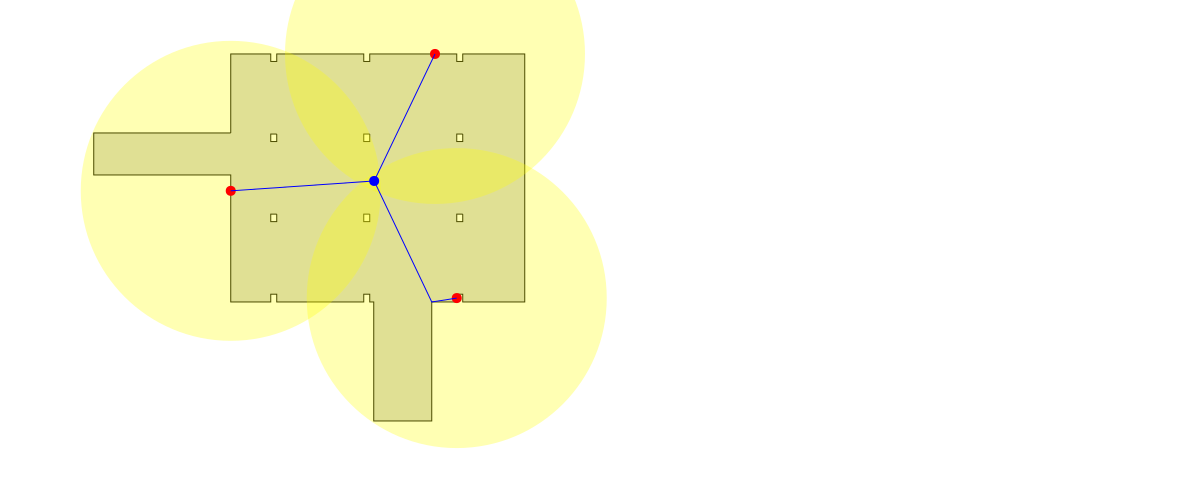

In [13]:
"""
PASS 2
- Make sure fire-route server is on!
- [x] Send navmesh
- [ ] Render shortest path
"""
import re
import requests
from geom.Line2D import distance2D

FIRE_ROUTE = "http://localhost:41982/travel"

def pathLength(path):
    dist = 0
    for i, l, in enumerate(path):
        if i == len(path) - 1: continue
        dist += distance2D(l, path[i+1])
        pass
    return dist

def drawTravel(drawing, start, end, stroke = "blue", failstroke = "orange", fill="none"):
    mesh = data["navmesh"]
    start = list(start[0:2])
    end = list(end[0:2])
    #print(start)
    payload = {"mesh": mesh, "start":start, "end": end}
    res = requests.post(FIRE_ROUTE, json = payload)

    travel = res.json()["result"]
    #print(res.json())
    distance = pathLength(travel)
    if(distance > 15000): stroke = failstroke
    tpath = dw.Path(stroke = 'blue', fill = 'none')
    for i, p in enumerate(travel):
        if(i == 0): tpath.M(p[0]/MM, -p[1]/MM); continue
        tpath.L(p[0]/MM, -p[1]/MM)
        pass
    drawing.append(tpath)
    return pathLength(travel)

d4 = deepcopy(d6)
tps = [tp, tp1, tp2]
pass2 = False
for pt in tps:
    dist = drawTravel(d4, pt, rp)
    if dist > 15000: pass2 = True
    pass

if pass2 == True:
    print("Pass 2: PASS")
else:
    print("Pass 2: FAIL")

d4

In [14]:
"""
Verdict
"""
if (pass1 == True and pass2 == True):
    print("Extinguisher placement PASSES")
else:
    print("Extinguisher placement FAILS")

Extinguisher placement PASSES
